In [1]:
import pandas as pd
# from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE

df = pd.read_csv('../SFDFD.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [3]:
df.isnull().values.any()

False

# Exploratory Data Analysis

In [4]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

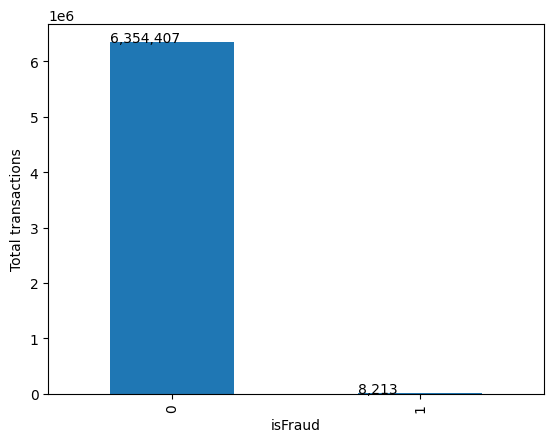

In [5]:
ax = pd.value_counts(df['isFraud']).plot(kind = 'bar')

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    ax.set_xlabel('isFraud')
    ax.set_ylabel('Total transactions')
plt.show()

Text(0, 0.5, 'No. of transactions')

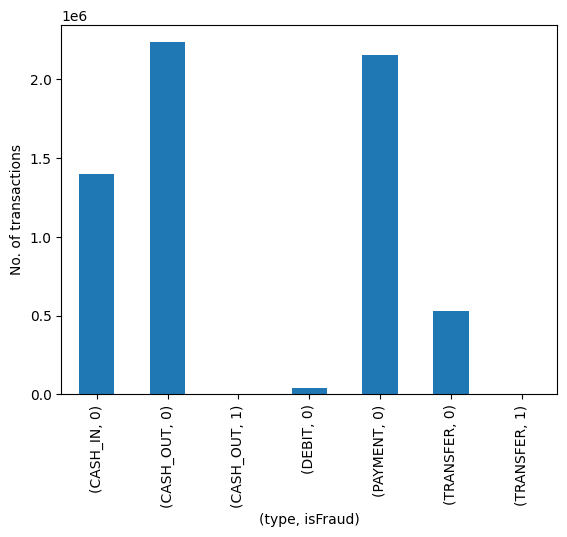

In [6]:
x_axis = df.groupby(['type', 'isFraud']).size().plot.bar()
x_axis.set_xlabel('(type, isFraud)')
x_axis.set_ylabel('No. of transactions')

In [7]:
df = df.loc[~(df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]

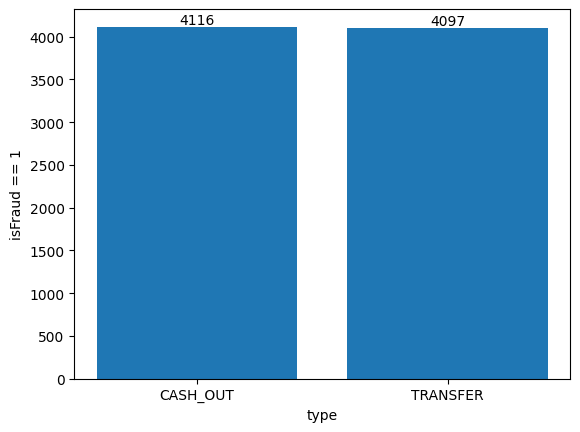

In [8]:
data_fraud = df[df.isFraud == 1] 
fraud_type_counts = data_fraud.type.value_counts(normalize=True)

cash_out_counts = data_fraud[data_fraud['type'] == 'CASH_OUT']['isFraud'].value_counts()
transfer_counts = data_fraud[data_fraud['type'] == 'TRANSFER']['isFraud'].value_counts()

# Plot the counts for CASH_OUT and TRANSFER separately
fig, ax = plt.subplots()
bars = ax.bar(['CASH_OUT', 'TRANSFER'], [cash_out_counts.get(1, 0), transfer_counts.get(1, 0)])
ax.set_xlabel('type')
ax.set_ylabel('isFraud == 1')

# Annotate the bars with the counts
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')


plt.show()

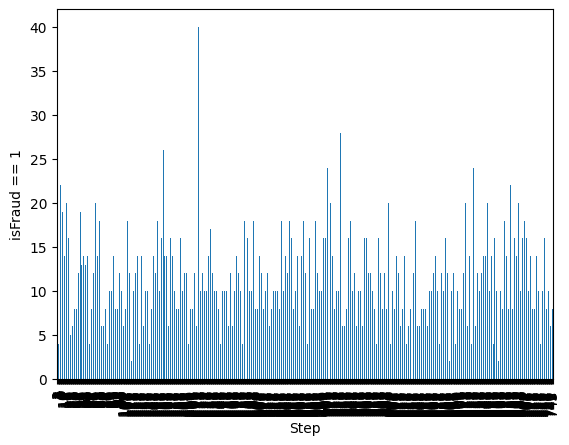

In [9]:
df_fraud = df['isFraud'].isin([1])

time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
time.set_xlabel('Step')
time.set_ylabel('isFraud == 1')
plt.show()

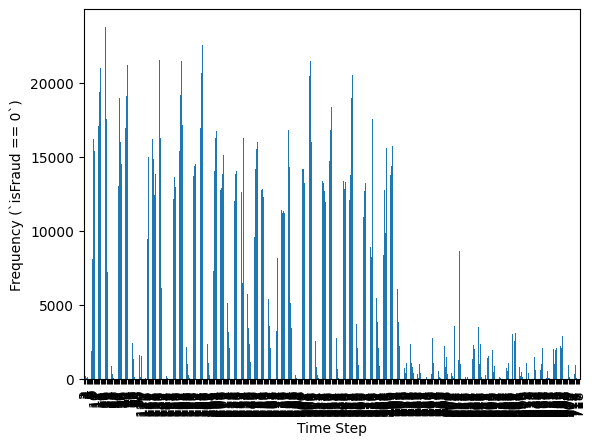

In [10]:
df_fraud = df['isFraud'].isin([0])

fraud_time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel('Time Step')
fraud_time.set_ylabel('Frequency (`isFraud == 0`)')
plt.show()

In [11]:
day = 1
for index in df['step'].index:
    i = df['step'].at[index]

    if i > [j for j in range(24, 800, 24)][day - 1]:
        day += 1

    df['step'].at[index] = (i - ((day - 1) * 24))

In [12]:
df['origBalance_inacc'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
df['destBalance_inacc'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']

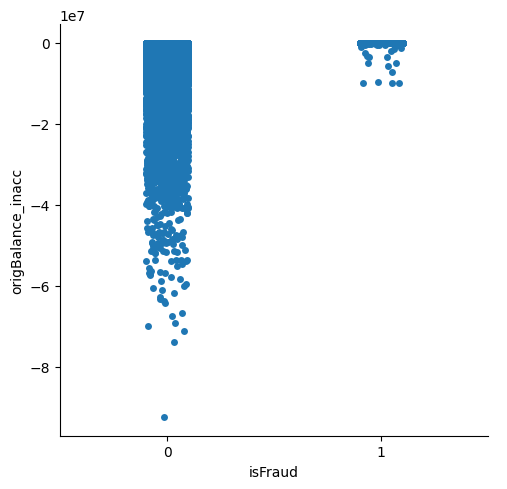

In [13]:
sns.catplot(data=df, x = df.isFraud, y = df.origBalance_inacc)

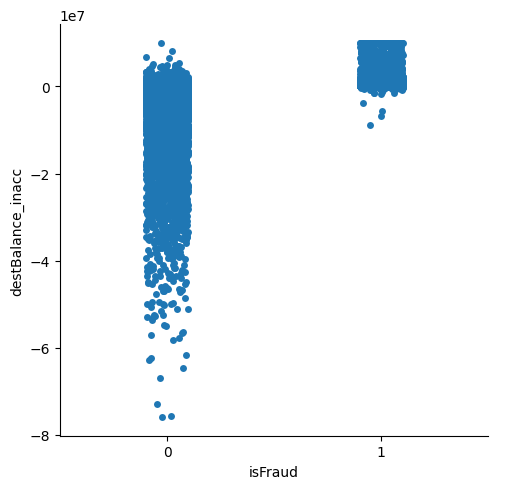

In [14]:
sns.catplot(data=df, x = df.isFraud, y = df.destBalance_inacc)

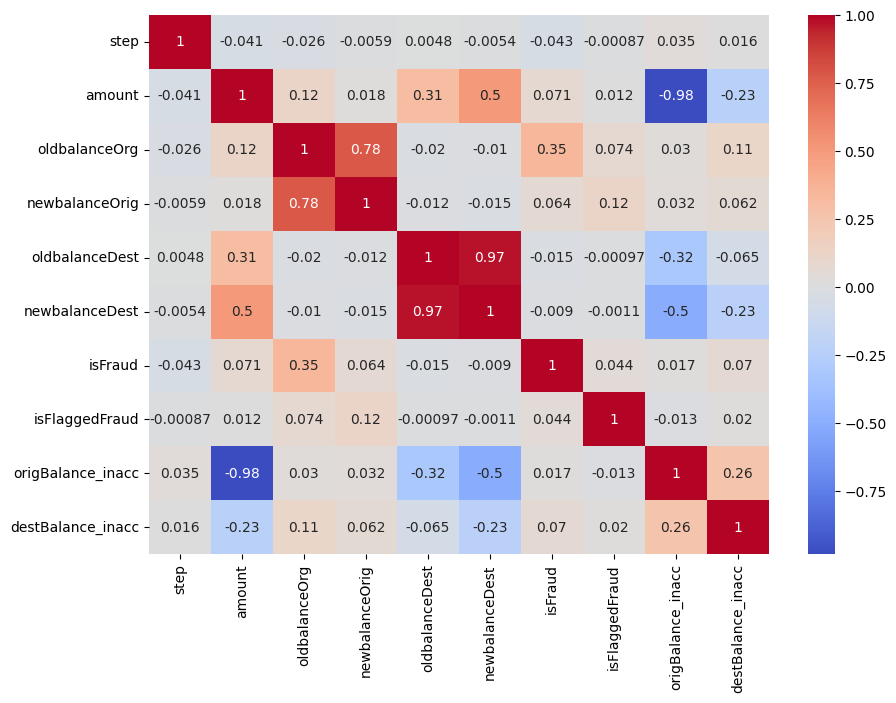

In [15]:
float_int_df = df.select_dtypes(include=['float64', 'int64'])

corr = float_int_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Data Preprocessing

In [16]:
df.drop(['newbalanceDest', 'newbalanceOrig', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1, inplace = True)

In [17]:
df = pd.get_dummies(df, columns=['type'], prefix=['type'])
df.dtypes

step                   int64
amount               float64
oldbalanceOrg        float64
oldbalanceDest       float64
isFraud                int64
origBalance_inacc    float64
destBalance_inacc    float64
type_CASH_OUT           bool
type_TRANSFER           bool
dtype: object

In [18]:
min_max_scaler = MinMaxScaler()

df_scaled = df.loc[:,~df.columns.isin(['isFraud', 'type_CASH_OUT', 'type_TRANSFER'])]
cols = df_scaled.columns
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_scaled))
df_scaled.columns = cols
cols = cols.tolist()
cols.append('isFraud')
cols.append('type_CASH_OUT')
cols.append('type_TRANSFER')

df_scaled_new = pd.DataFrame(columns = [cols])
for i in df_scaled.columns:
    df_scaled_new[i] = df_scaled[i]

df_scaled_new.reset_index(drop=True, inplace = True)
df.reset_index(drop=True, inplace = True)

for i in ['type_CASH_OUT', 'type_TRANSFER', 'isFraud']:
    df_scaled_new[i] = df[i]
    
df_scaled = df_scaled_new

In [19]:
X = df_scaled.drop(columns='isFraud')
y = df_scaled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

/var/folders/6n/pcltk5896ts9hbxrsn2fxxyw0000gn/T/ipykernel_32811/2272930155.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_scaled.drop(columns='isFraud')


In [20]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.values.ravel())
y_test = label_encoder.fit_transform(y_test.values.ravel())

# 1. Logistic Regression

In [21]:
smote = SMOTE()

# fit predictor and target features
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

model_lr = LogisticRegression()
model_lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred = model_lr.predict(X_test)

In [22]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.923579301739935
F1 score: 0.061470262282970076


# 2. Random Forest 

In [23]:
X = df.drop(columns='isFraud')
Y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

/Users/parthgupta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [24]:
# model_rf_parameters = {
#     'n_estimators' : [i for i in range(0, 501, 50)],
#     'max_depth' : [4, 5, 1, 2, None],
#     'min_samples_split' : [2, 3, 4, 5],
#     'min_samples_leaf' : [1, 4, 10, 20],
#     'max_leaf_nodes' : [2, 5, 10, None]   
# }

# model_rf_rscv = RandomizedSearchCV(rf, rf_parameters, cv=5, n_iter=5)
# model_rf_model_best = rf_rscv.fit(X_train, y_train)
# model_rf_model_best.best_estimator_

## Best parameters - min_samples_leaf=4, 
##                   min_samples_split=4

In [ ]:
model_rf_best = RandomForestClassifier(min_samples_leaf=4, min_samples_split=4, random_state=0)

model_rf_best.fit(X_train, y_train)
y_pred_best = model_rf_best.predict(X_test)

/Users/parthgupta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred_best))
print('F1 score:', f1_score(y_test, y_pred_best))